## <center>Logistic Regression and Evaluation Metrics</center>

In [3]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.10.12
import os

from IPython.display import Image
from IPython.display import display

# numpy 1.23.5
import numpy as np

# pandas 1.5.3
import pandas as pd

# scikit-learn 1.2.2
from scipy import interp
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import auc, confusion_matrix,  f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# cycler 0.10.0
# from cycler import cycler

# matplotlib  3.7.1
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt = matplotlib.pyplot

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

In [4]:
# load utility classes/functions e.g., plot_decision_regions()
import urllib.request

urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/04-1_Perceptron_Adaline/lab04lib.py", "lab04lib.py")

from lab04lib import *

import warnings
warnings.filterwarnings("ignore")


In this lab, we will guide you through the practice of Logistic Regression.

### Logistic Regression

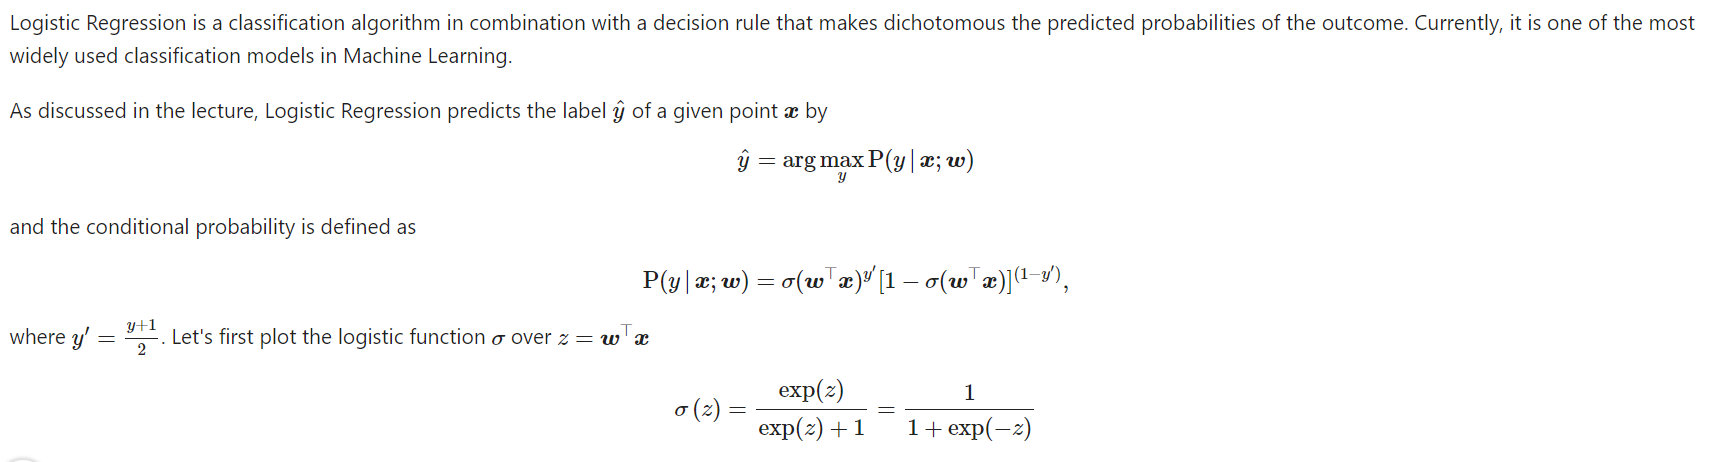

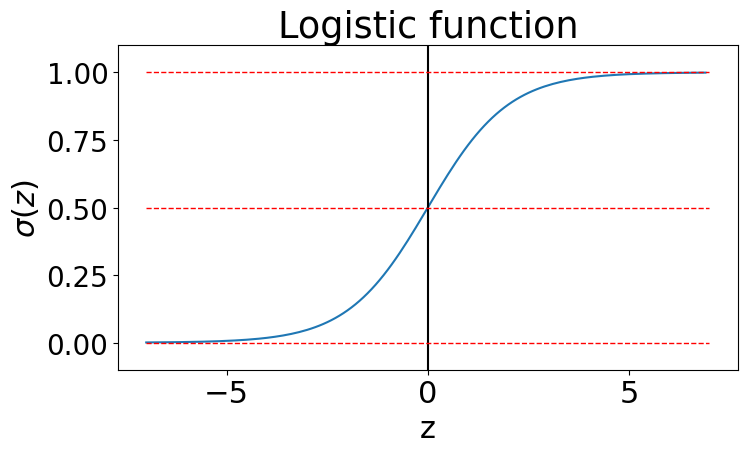

In [5]:
def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
sigma = logistic(z)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(z, sigma)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma(z)$')
plt.title('Logistic function')
plt.hlines(y=1.0, xmin=-7, xmax=7, color='red', linewidth = 1, linestyle = '--')
plt.hlines(y=0.5, xmin=-7, xmax=7, color='red', linewidth = 1, linestyle = '--')
plt.hlines(y=0, xmin=-7, xmax=7, color='red', linewidth = 1, linestyle = '--')
plt.tight_layout()
for item in (ax.get_yticklabels()):
    item.set_fontsize(20)
plt.savefig('./output/fig-logistic.png', dpi=300)
plt.show()

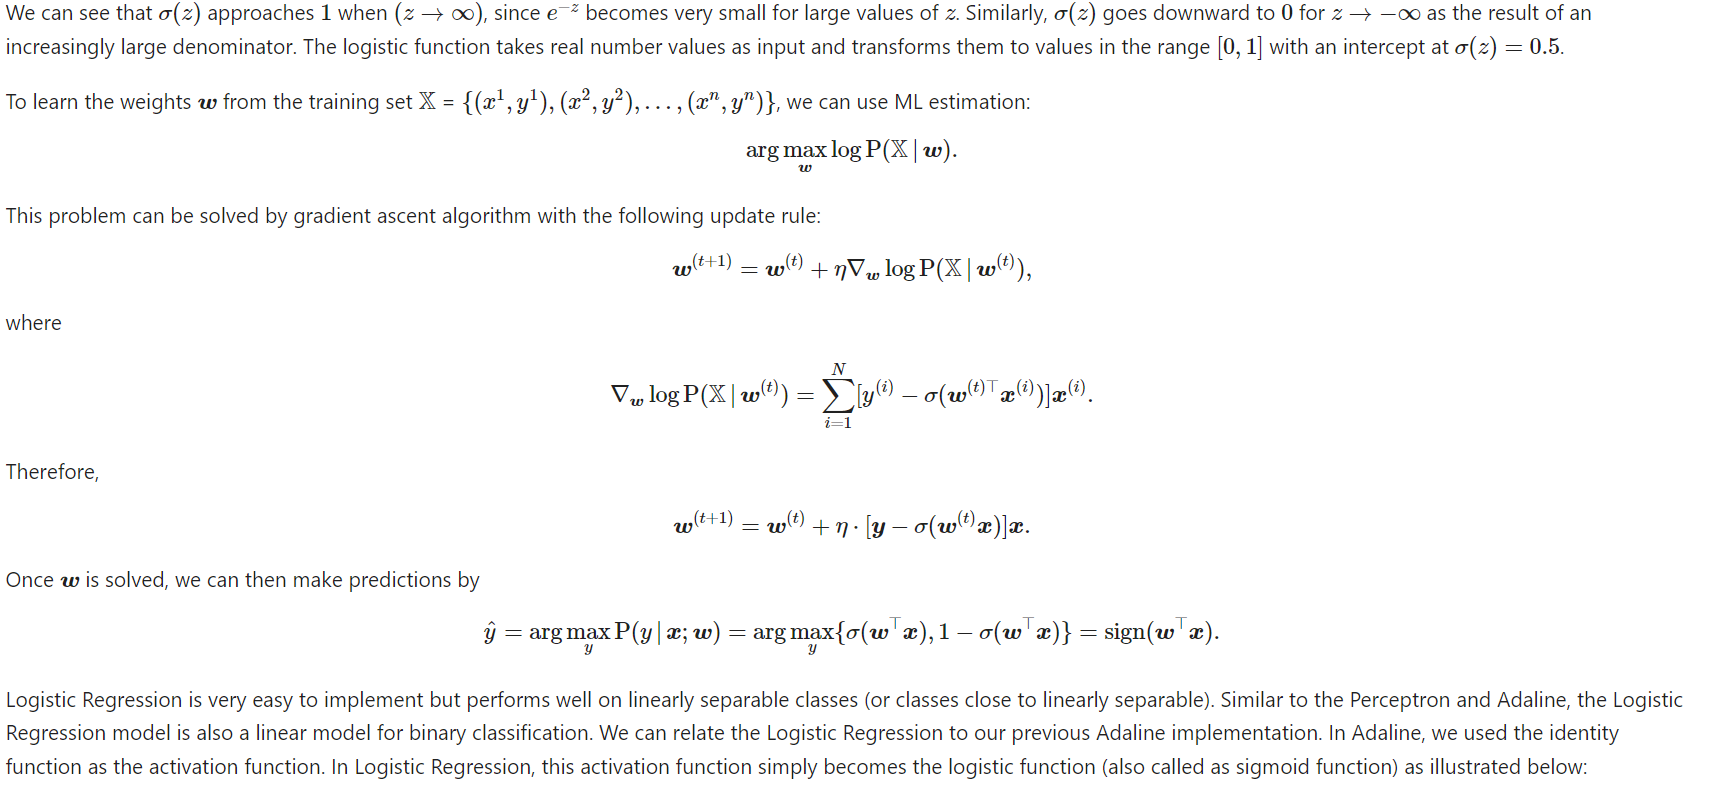
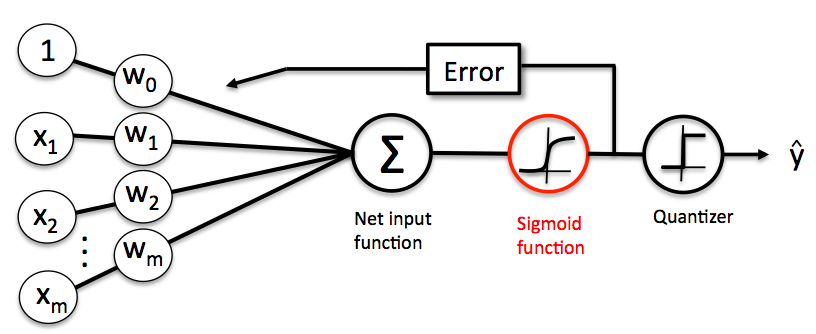

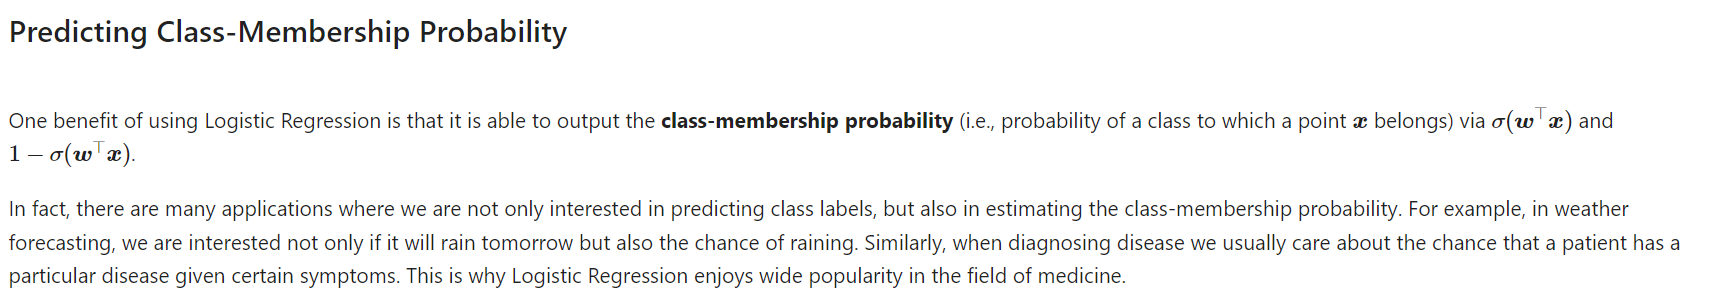

Training a Logistic Regression Model with Scikit-learn
Scikit-learn implements a highly optimized version of logistic regression that also supports multiclass classification off-the-shelf. Let's use it to make predictions on the standardized Iris training dataset.

NOTE: Logistic Regression, like many other binary classification models, can be easily extended to multiclass classification via [One-vs-All](https://scikit-learn.org/stable/modules/multiclass.html#one-vs-the-rest) or other similar techniques.

In [6]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

# for simplicity, consider only two features and two classes

X = df[['Petal length', 'Petal width']].values[50:150]
y, y_label = pd.factorize(df['Class label'].values[50:150])

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=1)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s (mapped from %s)' % (np.unique(y), np.unique(y_label)))

# Standardize X

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#Training data points: 80
#Testing data points: 20
Class labels: [0 1] (mapped from ['Iris-versicolor' 'Iris-virginica'])


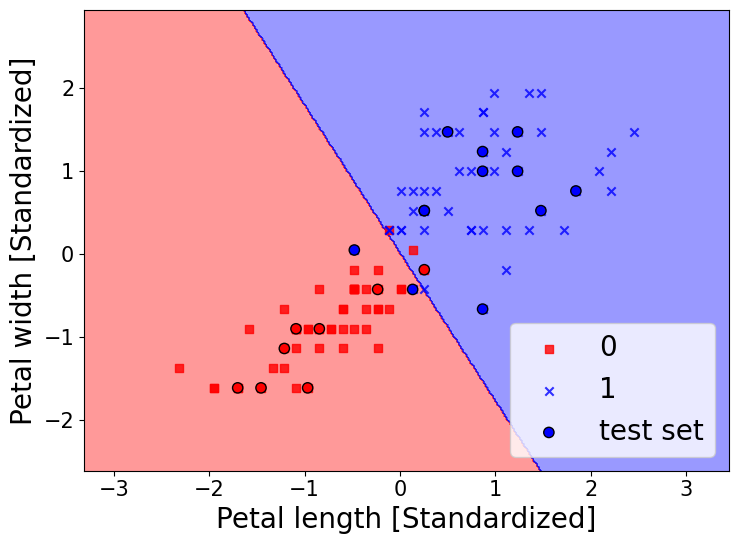

In [7]:
lr = LogisticRegression(C = 1000.0, random_state = 0, solver = "liblinear")
lr.fit(X_train_std, y_train)

# plot decision regions
fig, ax = plt.subplots(figsize=(8,6))
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(y_train.size,
                                                    y_train.size + y_test.size))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='lower right')
plt.tight_layout()
plt.legend(loc=4, prop={'size': 20})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-boundray-2.png', dpi=300)
plt.show()

The Logistic Regression class can predict the class-membership probability via the predict_proba() method. For example, we can predict the probabilities of the first testing point:

In [8]:
test_idx = 1
print('Correct label: %s\n' % y_label[y_test[test_idx]])

prob = lr.predict_proba(X_test_std[test_idx, :].reshape(1, -1))

print('Prob for class %s: %.2f' % (y_label[0], prob[:, 0]))
print('Prob for class %s: %.2f' % (y_label[1], prob[:, 1]))

Correct label: Iris-virginica

Prob for class Iris-versicolor: 0.01
Prob for class Iris-virginica: 0.99


The `prob` array tells us that the model predicts a 99% chance that the sample belongs to the Iris-Virginica class, and a 1% chance that the sample is a Iris-Versicolor flower.

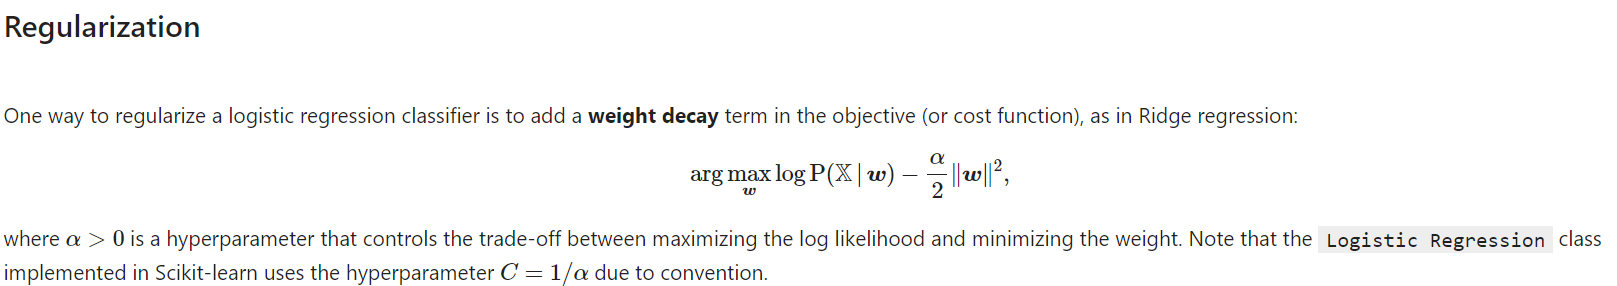

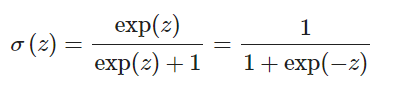

- z = $w^Tx + b$

- coef = w

- intercept = b

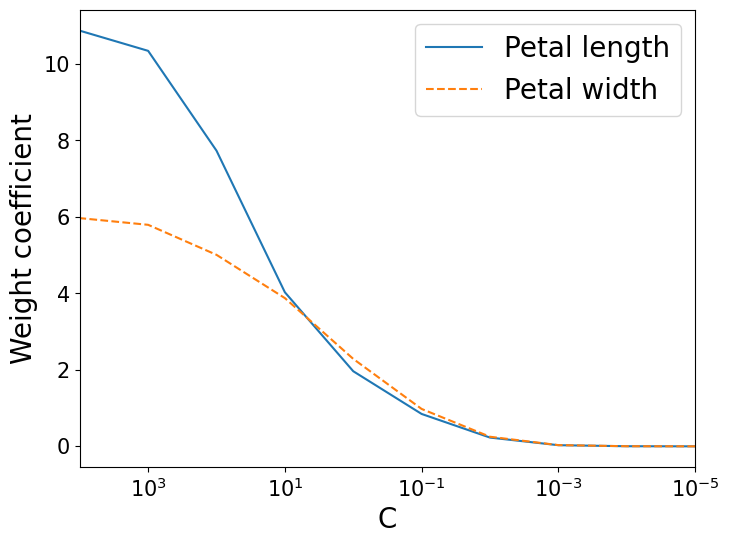

In [9]:
weights, params = [], []
for c in np.arange(-5, 5, dtype='float32'):
    lr = LogisticRegression(C = 10**c, random_state = 0, solver = "liblinear")
    lr.fit(X_train_std, y_train)
    # get the coefficients of w
    weights.append(lr.coef_[0])
    params.append(10**c)

fig, ax = plt.subplots(figsize=(8,6))
weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='Petal length')
plt.plot(params, weights[:, 1],
         label='Petal width', linestyle='--')
plt.xlim(10**4, 10**-5)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Weight coefficient')
plt.legend(loc='upper right')
plt.tight_layout()
plt.legend(loc=1, prop={'size': 20})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-c.png', dpi=300)
plt.show()

### Evaluation Metrics for Binary Classifiers

So far, we evaluate the performance of a classifier using the accuracy metric. Although accuracy is a general and common metric, there are several other evaluation metrics that allow us to quantify the performance of a model from different aspects.

### Confusion Matrix

Before we get into the details of different evaluation metrics, let's print the so-called confusion matrix, a square matrix that reports the counts of the true positive, true negative, false positive, and false negative predictions of a classifier, as shown below:

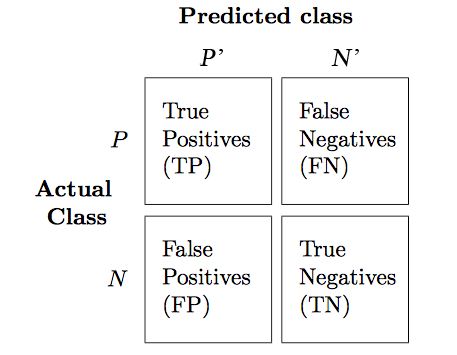

The confusion matrix of our logistic regressor over the Iris dataset is shown as follows:

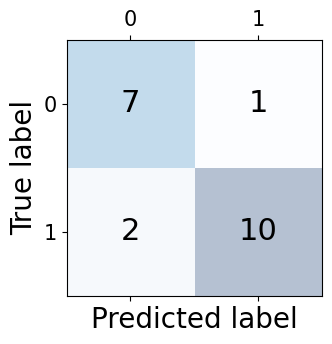

In [10]:
lr = LogisticRegression(random_state = 0, solver = "liblinear")
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('./output/fig-logistic-regression-confusion-2.png', dpi=300)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

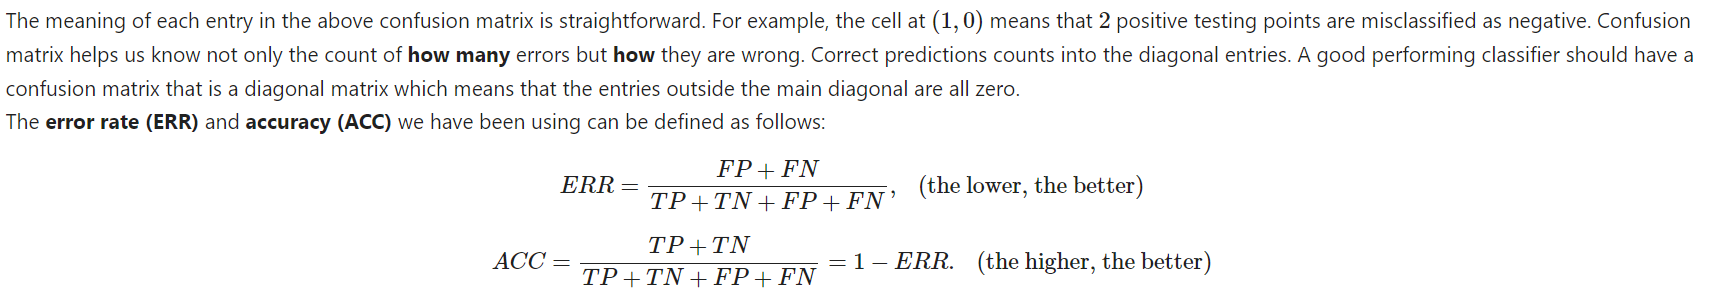

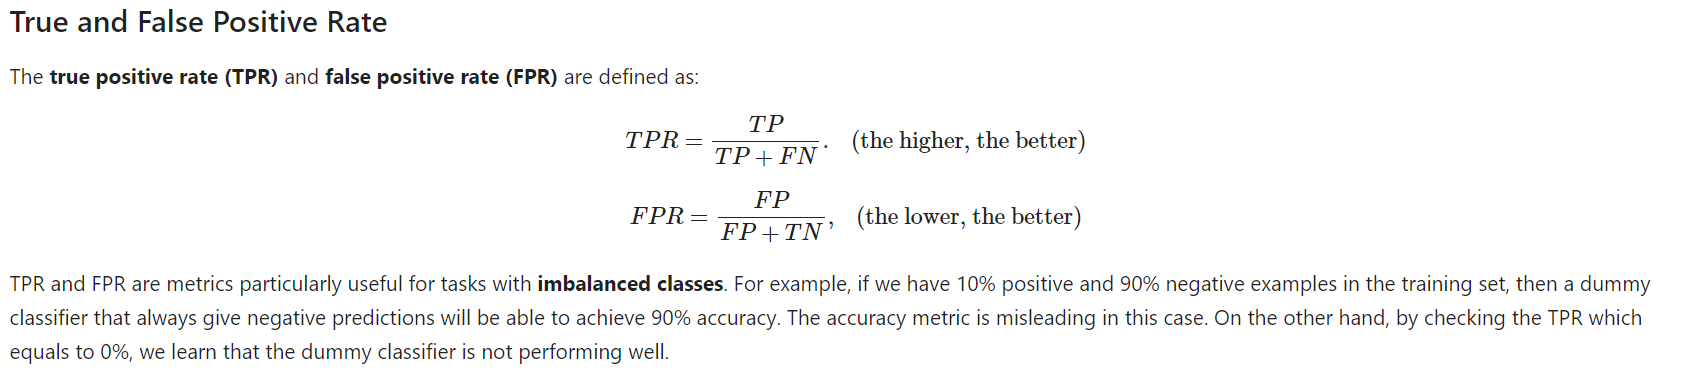

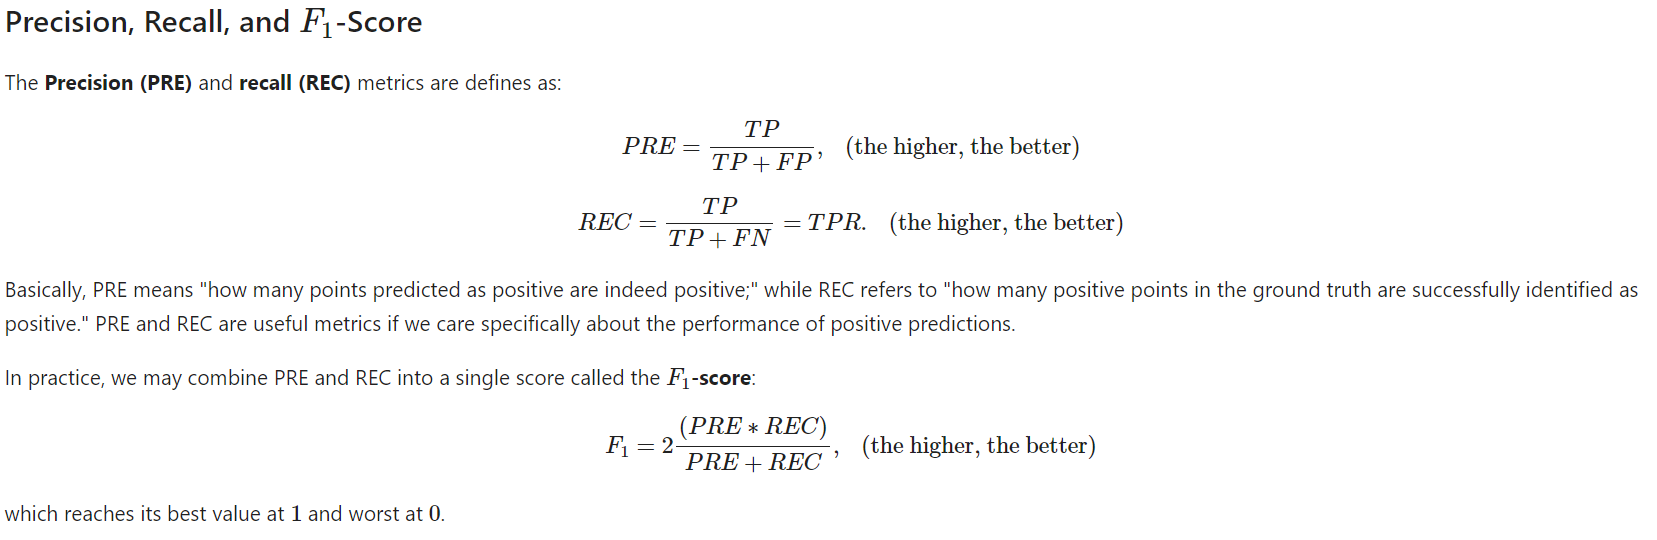

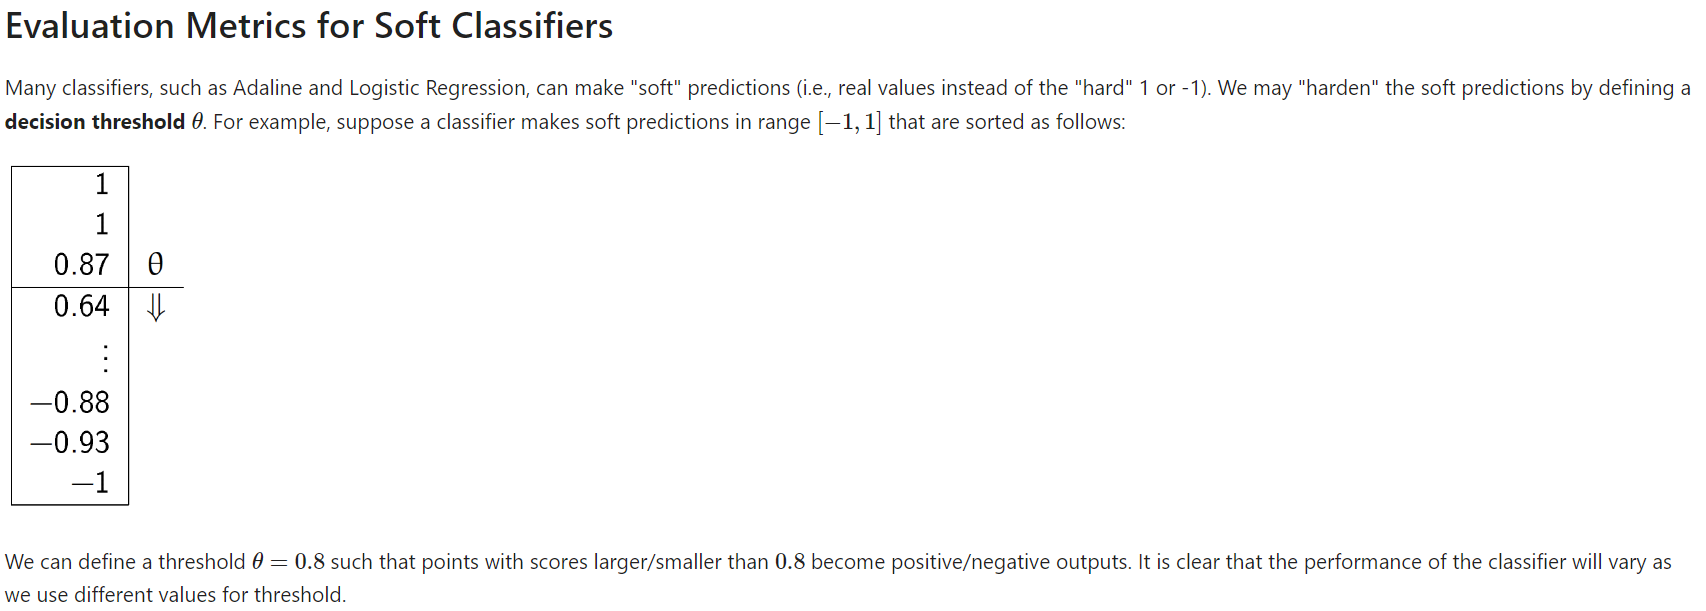

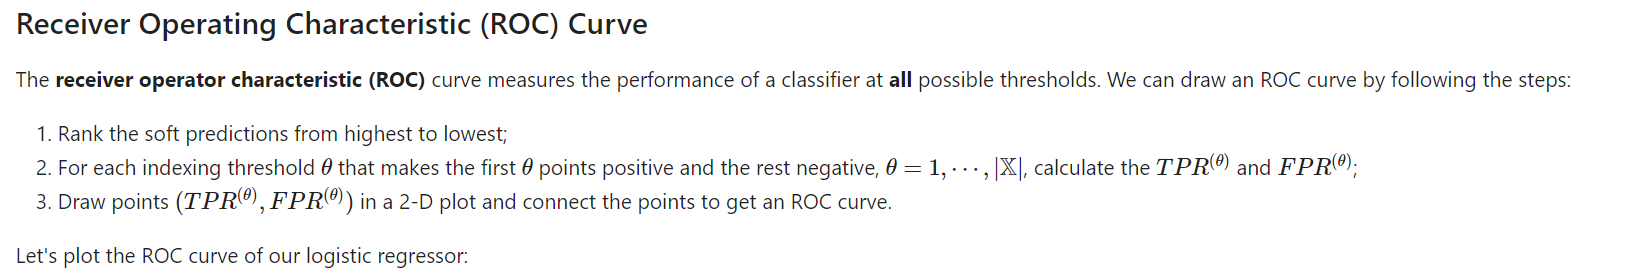

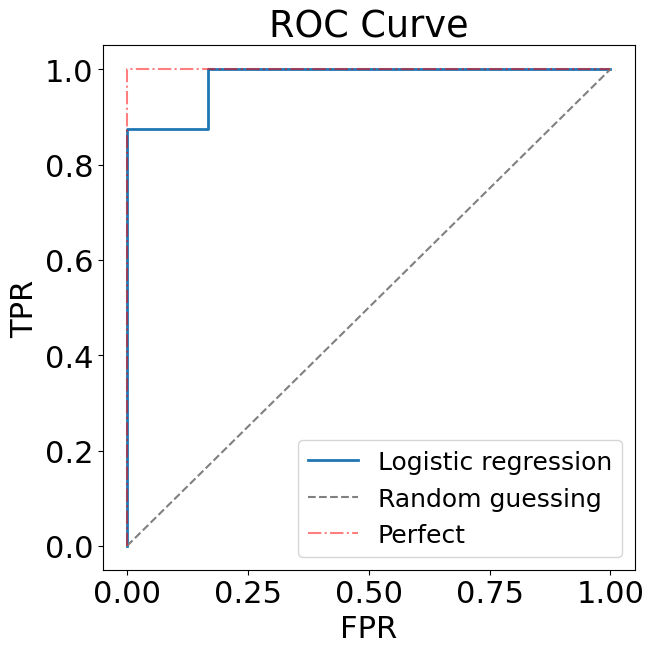

In [11]:
lr = LogisticRegression(random_state = 0, solver = "liblinear")
lr.fit(X_train_std, y_train)

fig = plt.figure(figsize=(7,7))

# mean_tpr = 0.0
# mean_fpr = np.linspace(0, 1, 100)
# all_tpr = []

probas = lr.predict_proba(X_test_std)

## we use feature 1 as positive label
fpr, tpr, thresholds = roc_curve(y_test,
                                 probas[:, 0],
                                 pos_label=0)

plt.plot(fpr, tpr, lw=2,
         label='Logistic regression')

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle='-.',
         alpha=0.5,
         color='red',
         label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-roc-lg.png', dpi=300)
plt.show()

### How does the ROC curve of a "good" classifier look like?

The ROC curve of a perfect classifier would have a line that goes from **bottom left** to **top left** and **top left** to top right. On the other hand, if the ROC curve is just the diagonal line then the model is just doing random guessing. Any useful classifier should have an ROC curve falling between these two curves.

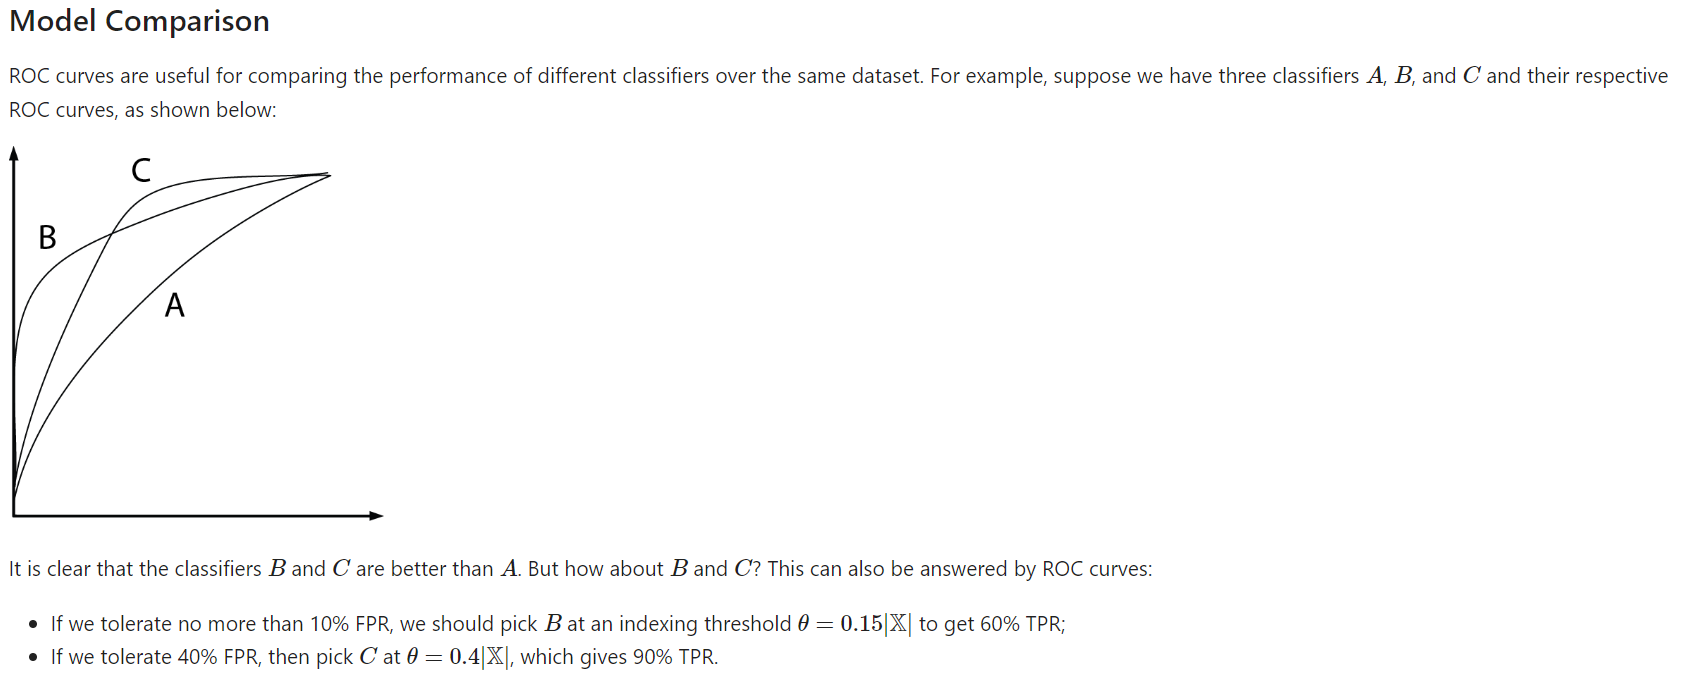

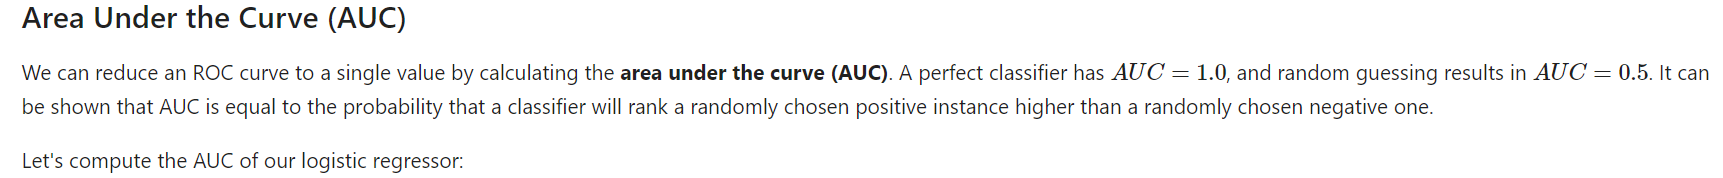

In [12]:
print('AUC: %.2f' % auc(fpr, tpr))

AUC: 0.98


That's a pretty high score!

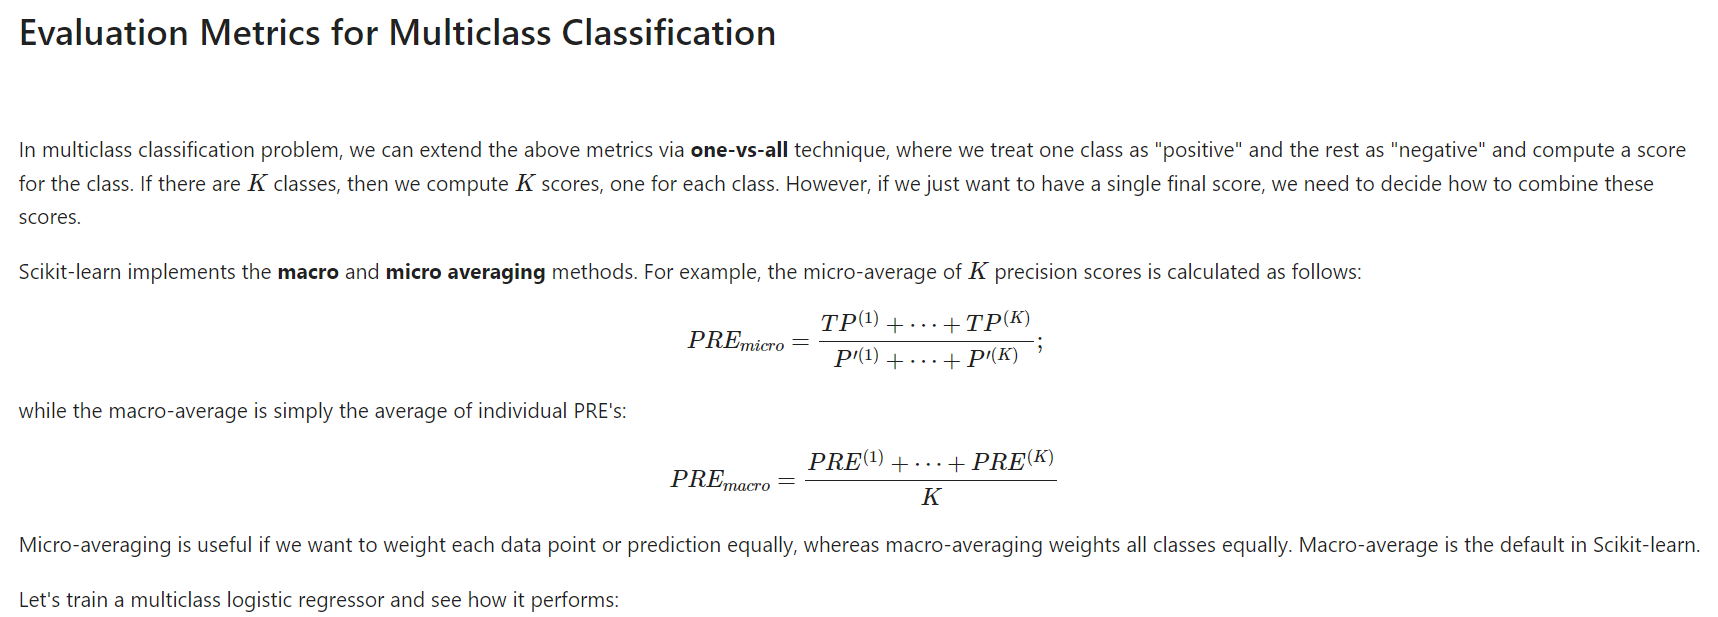

多分類分類的評估指標對於評估模型在處理多個類別或分類時的表現至關重要。在這種情況下，通常會將二元分類指標擴展到多分類情境。Scikit-learn提供了兩種常用的多類指標合併方法：微平均和宏平均。

1. **微平均**：

   微平均適用於當您希望每個數據點或預測都具有相等的重要性時。它通過將每個類別的單個真正例（TP）和預測正例（P'）相加，然後計算該指標。

   對於精確度（PR），可以表示為：

   ```latex
   PR_micro = (TP(1) + ... + TP(K)) / (P'(1) + ... + P'(K))
   ```

   這裡，TP(i)是類別 i 的真正例數，P'(i)是類別 i 的預測正例數。

2. **宏平均**：

   另一方面，宏平均通過分別為每個類別計算指標並取平均值，從而賦予所有類別相等的重要性。

   對於精確度（PR），計算如下：

   ```latex
   PR_macro = (PR(1) + ... + PR(K)) / K
   ```

   這裡，PR(i)是類別 i 的精確度，K 是類別的數量。

在Scikit-learn中，宏平均是合併多類別指標的默認方法。微平均在您希望平等強調每個數據點的貢獻時很有用，而宏平均確保最終指標中所有類別的重要性相同。

這些平均技術在多分類情境中評估模型的性能時特別有幫助，通常用於總結跨多個類別的模型性能。

#Training data points: 16 + 33 + 31 = 80
#Testing data points: 4 + 17 + 19 = 40
Class labels: [0 1 2] (mapped from ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica'])


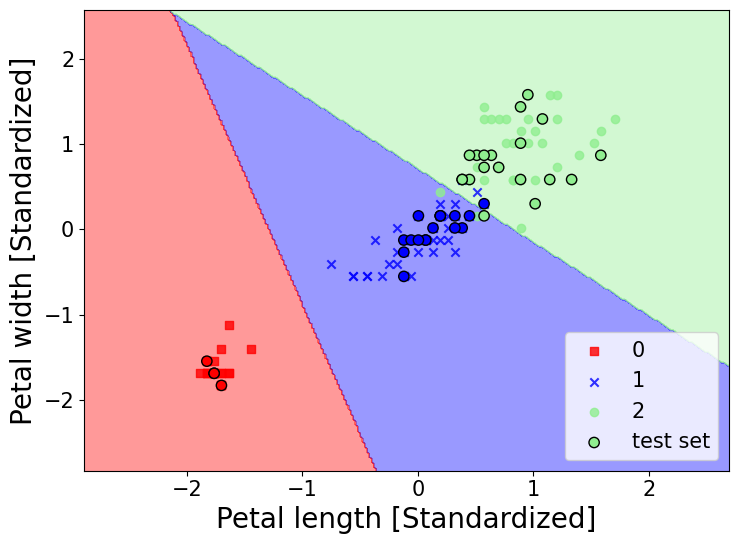

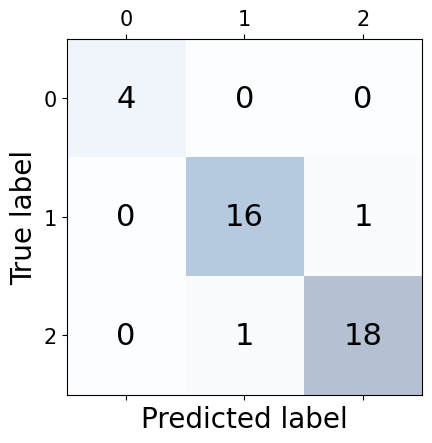

[Precision]
Individual: 1.00, 0.94, 0.95
Micro: 0.95
Macro: 0.96

[Recall]
Individual: 1.00, 0.94, 0.95
Micro: 0.95
Macro: 0.96

[F1-score]
Individual: 1.00, 0.94, 0.95
Micro: 0.95
Macro: 0.96


In [13]:
# prepare datasets

X = df[['Petal length', 'Petal width']].values[30:150,]
y, y_label = pd.factorize(df['Class label'].values[30:150])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1)

print('#Training data points: %d + %d + %d = %d' % ((y_train == 0).sum(),
                                                    (y_train == 1).sum(),
                                                    (y_train == 2).sum(),
                                                     y_train.size))
print('#Testing data points: %d + %d + %d = %d' % ((y_test == 0).sum(),
                                                    (y_test == 1).sum(),
                                                    (y_test == 2).sum(),
                                                     y_test.size))
print('Class labels: %s (mapped from %s)' % (np.unique(y), np.unique(y_label)))

# standarize X

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# training & testing

lr = LogisticRegression(C = 1000.0, random_state = 0, solver = "liblinear", multi_class = "ovr")
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)

# plot decision regions
fig, ax = plt.subplots(figsize=(8,6))

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(y_train.size,
                                     y_train.size + y_test.size))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc=4, prop={'size': 15})
plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-boundray-3.png', dpi=300)
plt.show()

# plot confusion matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-confusion-3.png', dpi=300)
plt.show()

# metrics

print('[Precision]')
p = precision_score(y_true=y_test, y_pred=y_pred, average=None)
print('Individual: %.2f, %.2f, %.2f' % (p[0], p[1], p[2]))
p = precision_score(y_true=y_test, y_pred=y_pred, average='micro')
print('Micro: %.2f' % p)
p = precision_score(y_true=y_test, y_pred=y_pred, average='macro')
print('Macro: %.2f' % p)

print('\n[Recall]')
r = recall_score(y_true=y_test, y_pred=y_pred,average=None)
print('Individual: %.2f, %.2f, %.2f' % (r[0], r[1], r[2]))
r = recall_score(y_true=y_test, y_pred=y_pred, average='micro')
print('Micro: %.2f' % r)
r = recall_score(y_true=y_test, y_pred=y_pred, average='macro')
print('Macro: %.2f' % r)

print('\n[F1-score]')
f = f1_score(y_true=y_test, y_pred=y_pred, average=None)
print('Individual: %.2f, %.2f, %.2f' % (f[0], f[1], f[2]))
f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
print('Micro: %.2f' % f)
f = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
print('Macro: %.2f' % f)

We can see that the micro average reports more conservative scores. This is because it takes into account the class size. In our testing set, the first class is smaller than the others so its score (1.00) contributes less to the final score.